# Shape optimization of trusses

Shape optimization means that given a fixed topology of a truss, we want optimize its stiffness by modifying some node positions.


In [1]:
from math import sqrt

import torch

from torchfem import Truss
from torchfem.materials import IsotropicElasticity1D

torch.set_default_dtype(torch.double)

In [2]:
# Create material
material = IsotropicElasticity1D(500.0)

## Truss definition

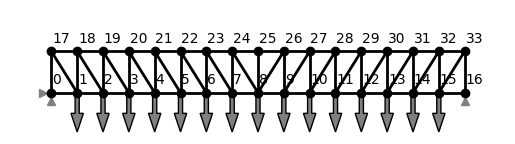

In [3]:
# Dimensions
A = 17
B = 2

# Nodes
n1 = torch.linspace(0.0, 5.0, A)
n2 = torch.linspace(0.0, 0.5, B)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Elements
connections = []
for i in range(A - 1):
    for j in range(B):
        connections.append([i + j * A, i + 1 + j * A])
for i in range(A):
    for j in range(B - 1):
        connections.append([i + j * A, i + A + j * A])
for i in range(A - 1):
    for j in range(B - 1):
        if i >= (A - 1) / 2:
            connections.append([i + j * A, i + 1 + A + j * A])
        else:
            connections.append([i + 1 + j * A, i + A + j * A])
elements = torch.tensor(connections)

# Truss
bridge = Truss(nodes.clone(), elements, material)

# Forces at bottom edge
bridge.forces[1 : A - 1, 1] = -0.1

# Constraints by the supports
bridge.constraints[0, 0] = True
bridge.constraints[0, 1] = True
bridge.constraints[A - 1, 1] = True

# Plot
bridge.plot()

## Helper functions

In [4]:
def compute_lengths(truss):
    start_nodes = truss.nodes[truss.elements[:, 0]]
    end_nodes = truss.nodes[truss.elements[:, 1]]
    dx = end_nodes - start_nodes
    return torch.linalg.norm(dx, dim=-1)


def box_constrained_decent(
    func, x_init, x_lower, x_upper, eta=0.01, max_iter=100, tol=1e-10
):
    x = x_init.clone().requires_grad_()
    for _ in range(max_iter):
        x_old = x.clone()
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        x = x - eta * grad
        x = torch.clamp(x, x_lower, x_upper)
        if torch.norm(x - x_old) < tol:
            return x
    return x


def MMA(func, x_k, L_k, U_k):
    x_lin = x_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(x_lin), x_lin)[0]
    pg = grads >= 0.0
    ng = grads < 0.0
    f_k = func(x_k)

    def approximation(x):
        p = torch.zeros_like(grads)
        p[pg] = (U_k[pg] - x_k[pg]) ** 2 * grads[pg]
        q = torch.zeros_like(grads)
        q[ng] = -((x_k[ng] - L_k[ng]) ** 2) * grads[ng]
        return (
            f_k
            - torch.sum(p / (U_k - x_k) + q / (x_k - L_k))
            + torch.sum(p / (U_k - x) + q / (x - L_k))
        )

    return approximation, grads

## Initial parameters and ranges

In [5]:
# Mask for design variables.
mask = torch.zeros_like(nodes, dtype=bool)
mask[A : 2 * A, 1] = True

# Limits on design variables
x_0 = nodes[mask].ravel()
x_min = x_0 - 0.4
x_max = x_0 + 0.5

# Compute current volume
l = compute_lengths(bridge)
V0 = torch.inner(bridge.areas, l)

## Optimization

We will optimize the shape of the truss by minimizing the compliance of the bridge by adjusting the top nodes while keeping the volume constant: 

$$
\min_{\mathbf{x}} \quad C(\mathbf{x}) = \mathbf{f} \cdot \mathbf{u}(\mathbf{x}) \\
\text{s.t.} \quad \mathbf{a} \cdot \mathbf{l}(\mathbf{x}) - V_0 \le 0\\
\quad \quad x \in [\mathbf{x}^{-}, \mathbf{x}^{+}]
$$

In [6]:
def f(x):
    # Update nodes
    bridge.nodes[mask] = x
    # Solve truss with updated nodes
    u_k, f_k, _, _, _ = bridge.solve()
    # Return compliance
    return torch.inner(f_k.ravel(), u_k.ravel())

In [7]:
def g(x):
    # Update nodes
    bridge.nodes[mask] = x
    # Return constraint function
    return torch.inner(bridge.areas, compute_lengths(bridge)) - V0

In [8]:
s = 0.7

# Set up lists for L, U, x
L = []
U = []
x = [x_0]

# Define the initial value, lower bound, and upper bound of "mu"
mu_0 = torch.tensor([0.01])
mu_lower = torch.tensor([1e-10])
mu_upper = None

for k in range(50):
    # Update asymptotes with heuristic procedure (see Exercise 04)
    if k <= 1:
        L.append(x[k] - s * (x_max - x_min))
        U.append(x[k] + s * (x_max - x_min))
    else:
        L_k = torch.zeros_like(L[k - 1])
        U_k = torch.zeros_like(U[k - 1])
        # Shrink all oscillating asymptotes
        osci = (x[k] - x[k - 1]) * (x[k - 1] - x[k - 2]) < 0.0
        L_k[osci] = x[k][osci] - s * (x[k - 1][osci] - L[k - 1][osci])
        U_k[osci] = x[k][osci] + s * (U[k - 1][osci] - x[k - 1][osci])
        # Expand all non-oscillating asymptotes
        L_k[~osci] = x[k][~osci] - 1 / sqrt(s) * (x[k - 1][~osci] - L[k - 1][~osci])
        U_k[~osci] = x[k][~osci] + 1 / sqrt(s) * (U[k - 1][~osci] - x[k - 1][~osci])
        L.append(L_k)
        U.append(U_k)

    # Compute lower and upper move limit in this step
    x_min_k = torch.max(x_min, 0.9 * L[k] + 0.1 * x[k])
    x_max_k = torch.min(x_max, 0.9 * U[k] + 0.1 * x[k])

    # Compute the current approximation function and save gradients
    f_tilde, f_grad = MMA(f, x[k], L[k], U[k])
    g_tilde, g_grad = MMA(g, x[k], L[k], U[k])

    # Define the Lagrangian
    def lagrangian(x, mu):
        return f_tilde(x) + mu * g_tilde(x)

    # Define x_star by minimizing the Lagrangian w. r. t. x analytically
    def x_star(mu):
        x_hat = torch.zeros_like(f_grad)
        # Case 1
        cond1 = (f_grad > 0.0) & (g_grad > 0.0)
        x_hat[cond1] = x_min[cond1]
        # Case 2
        cond2 = (f_grad < 0.0) & (g_grad < 0.0)
        x_hat[cond2] = x_max[cond2]
        # Case 3
        cond3 = (f_grad > 0.0) & (g_grad < 0.0)
        roots = torch.sqrt(
            (-mu * g_grad[cond3] * (x[k][cond3] - L[k][cond3]) ** 2)
            / (U[k][cond3] - x[k][cond3]) ** 2
            / f_grad[cond3]
        )
        x_hat[cond3] = (U[k][cond3] * roots + L[k][cond3]) / (1 + roots)
        # Case 4
        cond4 = (f_grad < 0.0) & (g_grad > 0.0)
        roots = torch.sqrt(
            (-mu * g_grad[cond4] * (U[k][cond4] - x[k][cond4]) ** 2)
            / (x[k][cond4] - L[k][cond4]) ** 2
            / f_grad[cond4]
        )
        x_hat[cond4] = (U[k][cond4] + L[k][cond4] * roots) / (1 + roots)
        return torch.clamp(x_hat, x_min_k, x_max_k)

    # Define (-1 times) the dual function
    def dual_function(mu):
        return -lagrangian(x_star(mu), mu)

    # Compute the maximum of the dual function
    mu_star = box_constrained_decent(dual_function, mu_0, mu_lower, mu_upper, eta=0.01)

    # Compute current optimal point with dual solution
    x.append(x_star(mu_star).detach())

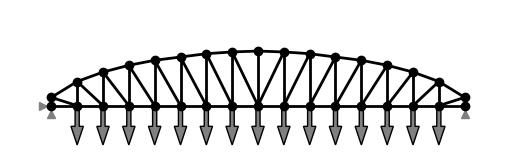

In [9]:
# Plot the optimized bridge
bridge.plot(node_labels=False)